# Rossman Store - ARIMA / SARIMA Model Implementation

In [1]:
# help documentation
# https://www.statsmodels.org/stable/tsa.html


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from pathlib import Path
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# read the dataset

# file_dir = Path('/Users/khan_m_a/Google Drive/Data_Science/projects/6 Real Time Porjects/Data Science for Business Package/3. Sales Department Data')
# df = pd.read_csv(file_dir / 'train_all.csv',
#                 index_col = 'Date', # Date is read as index
#                 parse_dates = True # date as datetime64
#                 )
df = pd.read_csv('train.csv', #'train_store.csv',
                index_col = 'Date', # Date as index
                parse_dates = True  # Date as datetime64
                )
# df.set_index('Date') # to set date as index
# df['Date'] = pd.to_datetime(df['Date']) # antoher way to change date to datetime64

In [5]:
df.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [6]:
df.index.values

array(['2015-07-31T00:00:00.000000000', '2015-07-31T00:00:00.000000000',
       '2015-07-31T00:00:00.000000000', ...,
       '2013-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2013-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [8]:
df.head(3)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1


In [9]:
# adding one more column s sales per customer 
df['Sales per customer'] = df['Sales'] / df['Customers']
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales per customer
Date,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,8.626118


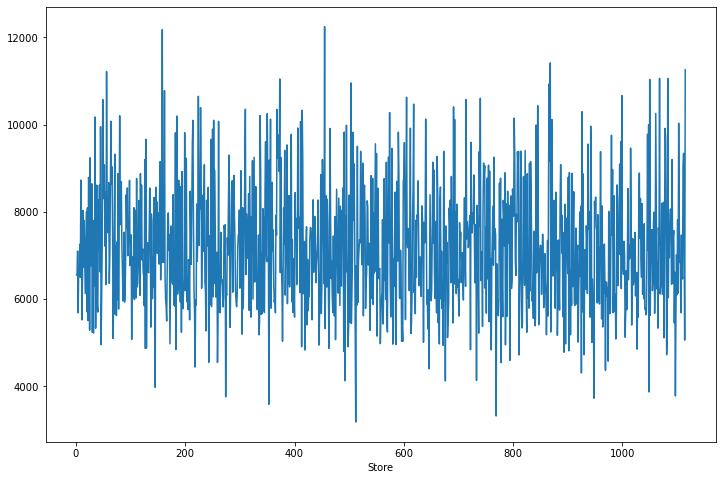

In [10]:
df.groupby('Store')['Sales per customer'].sum().plot(figsize = (12,8));

In [11]:
# checking the biggest store 

biggest_stores = df['Store'].value_counts(ascending = False)
biggest_stores


1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

In [12]:
# let's search only for store = 85
df = df[df['Store'] == 1023]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2015-07-31 to 2013-01-01
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Store               942 non-null    int64  
 1   DayOfWeek           942 non-null    int64  
 2   Sales               942 non-null    int64  
 3   Customers           942 non-null    int64  
 4   Open                942 non-null    int64  
 5   Promo               942 non-null    int64  
 6   StateHoliday        942 non-null    object 
 7   SchoolHoliday       942 non-null    int64  
 8   Sales per customer  780 non-null    float64
dtypes: float64(1), int64(7), object(1)
memory usage: 73.6+ KB
None


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales per customer
Date,,,,,,,,,
2015-07-31,1023,5,7182,649,1,1,0,1,11.066256
2015-07-30,1023,4,6348,603,1,1,0,1,10.527363
2015-07-29,1023,3,6010,544,1,1,0,1,11.047794
2015-07-28,1023,2,6470,588,1,1,0,1,11.003401
2015-07-27,1023,1,8230,701,1,1,0,1,11.740371


In [13]:
# checking for weekly
print(len(df))
df = df.resample(rule = 'W').sum()
df.index.freq = 'W'
print(len(df))

942
135


In [14]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Sales per customer
Date,,,,,,,,
2013-01-06,6138,27,20754,2554,4,0,2,32.447903
2013-01-13,7161,28,41474,4280,6,5,0,58.029085
2013-01-20,7161,28,28176,3292,6,0,0,51.254288
2013-01-27,7161,28,38850,3939,6,5,0,59.157119
2013-02-03,7161,28,31825,3529,6,0,0,53.839307


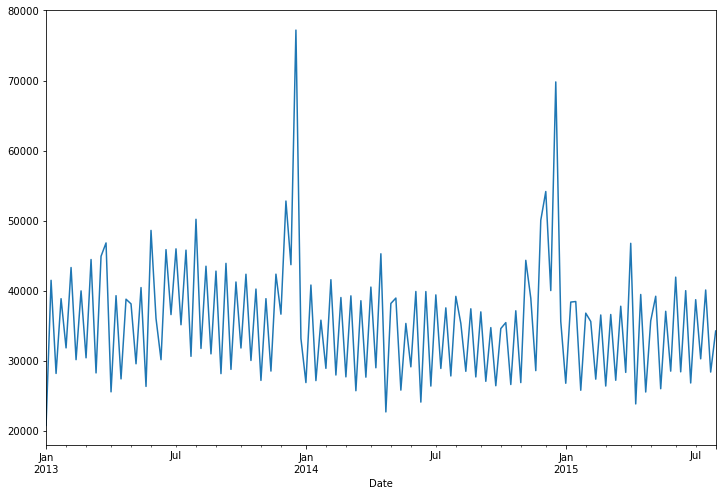

In [15]:
df['Sales'].plot(figsize = (12,8));

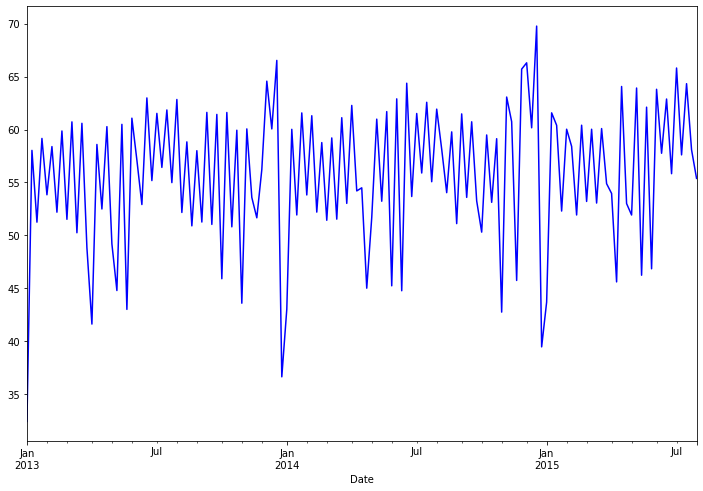

In [16]:
df['Sales per customer'].plot(figsize = (12,8), color = 'b');

Observations :

(1) There is a seasonality in the month of December due to holiday shopping.

(2) Sales per customer drops in January probably because customer has spent all their money during holidays.

# Moving Average and Exponential Weighted Average

Text(0.5, 1.0, 'Comparison of MA, EWA, and Original')

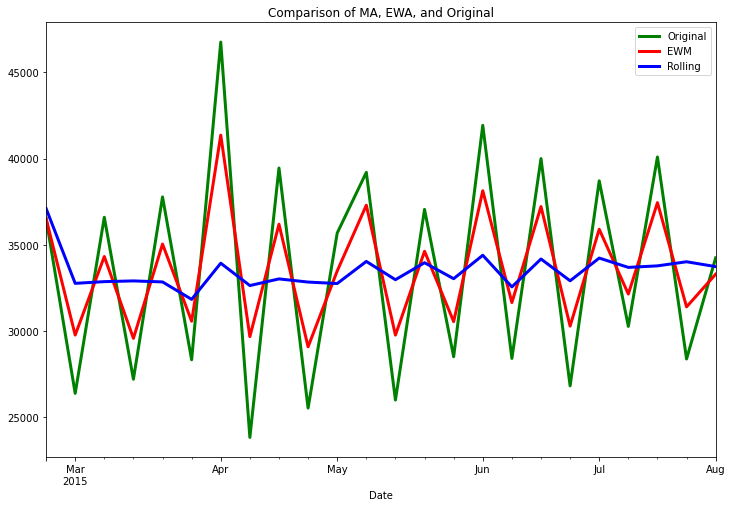

In [17]:
# visualize on last year sales with rolling window / Expnontial Weigheing moving average
# only the last 24 weeks are used for visualization
# span = 52
# alpha = 2/(span + 1)
fig, ax = plt.subplots()
df['Sales'].iloc[-24:].plot(color = 'g', linewidth = 3, figsize = (12,8)); #legend = True, 
df['Sales'].iloc[-24:].ewm(span= 2, adjust = False).mean().plot(color = 'r', linewidth = 3) # span indicated no. of days in EWMA
df.rolling(window = 10).mean()['Sales'].iloc[-24:].plot( color = 'b', linewidth = 3);
ax.legend(['Original', 'EWM', 'Rolling'])
plt.title('Comparison of MA, EWA, and Original')

Observation:

(1) As we know, the EMW can not reach the peak of orginal which is clearly seen here.

(2) Rolling MA is almost like a flat line

In [18]:
df.index

DatetimeIndex(['2013-01-06', '2013-01-13', '2013-01-20', '2013-01-27',
               '2013-02-03', '2013-02-10', '2013-02-17', '2013-02-24',
               '2013-03-03', '2013-03-10',
               ...
               '2015-05-31', '2015-06-07', '2015-06-14', '2015-06-21',
               '2015-06-28', '2015-07-05', '2015-07-12', '2015-07-19',
               '2015-07-26', '2015-08-02'],
              dtype='datetime64[ns]', name='Date', length=135, freq='W-SUN')

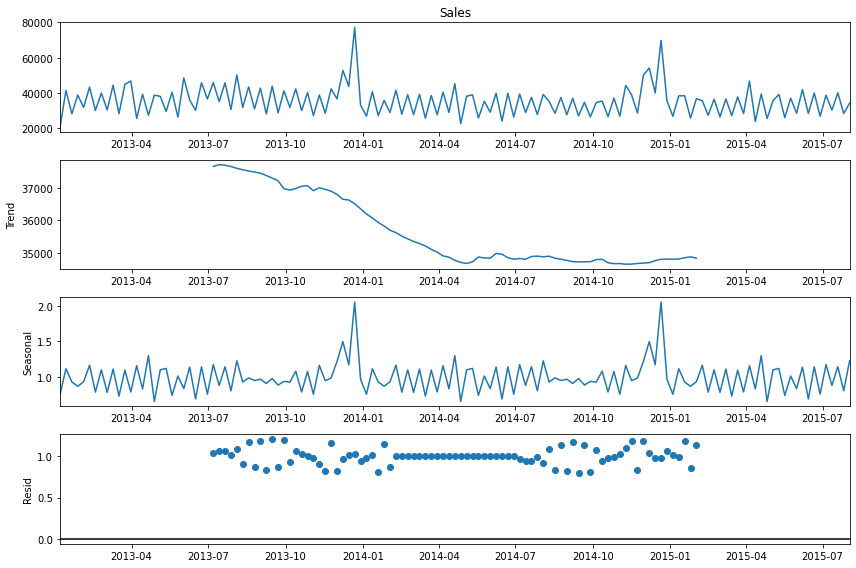

In [19]:

results = seasonal_decompose(df['Sales'], model = 'multiplicative') #'additive');
results.plot();

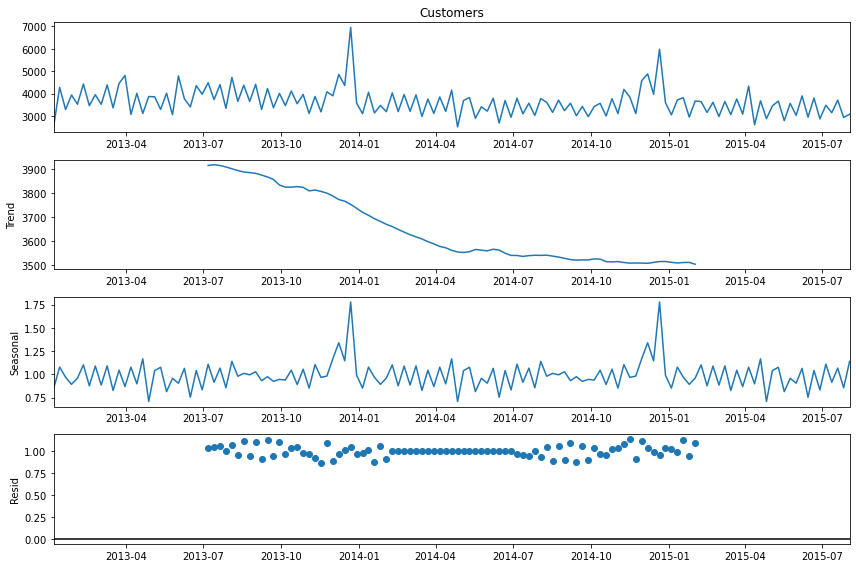

In [20]:
results = seasonal_decompose(df['Customers'], model = 'multiplicative');
results.plot();

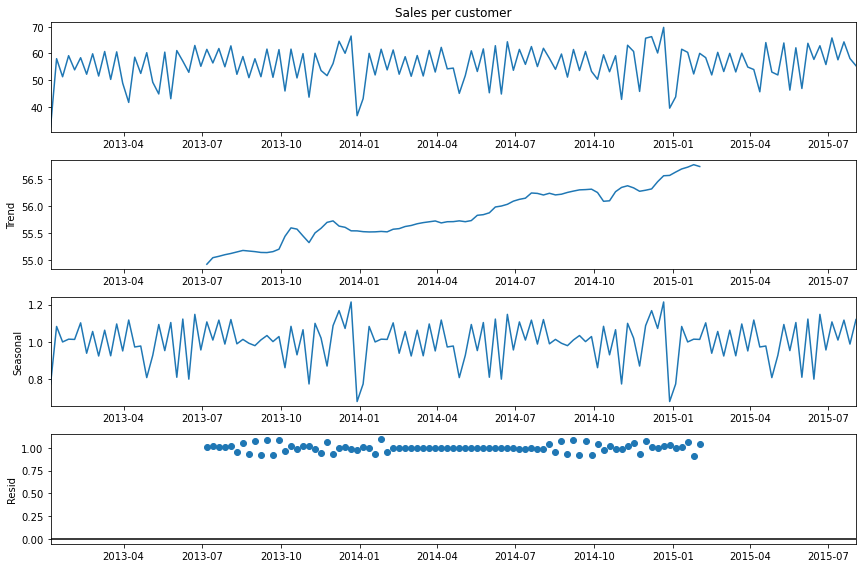

In [21]:
results = seasonal_decompose(df['Sales per customer'], model = 'multiplicative');
results.plot();

# Check for Stationary (AD Fuller Test)

In [22]:
# Augmented Dickey Fuller Test


def adfuller_test(series):
    '''
    Null Hypthesis is that series is not stationary.
    if p_val > 0.5, we fail to reject the hypothesis but 
    we can not accept the hypothesis.
    '''
    
    result = adfuller(series.dropna(), autolag = 'AIC') # dropna for removing differentiated data
    labels = ['ADF Test', 'p_value', 'No. of leg used', 'No. of observations']
    
    out = pd.Series(result[0:4], index = labels)
    print(out.head())
    
    if result[1] <= 0.5: # if p_value is less than significant level
        print('Reject the Null Hypothesis')
        print('Data has no unit root and is stationary')
    else:
        print('Fail to reject the Null Hypothesis')
        print('Data has unit root and is not stationary')
    


In [23]:
adfuller_test(df['Sales'])

ADF Test              -6.017041e+00
p_value                1.524938e-07
No. of leg used        1.000000e+00
No. of observations    1.330000e+02
dtype: float64
Reject the Null Hypothesis
Data has no unit root and is stationary


In [24]:
adfuller_test(df['Customers'])

ADF Test                -5.245751
p_value                  0.000007
No. of leg used          1.000000
No. of observations    133.000000
dtype: float64
Reject the Null Hypothesis
Data has no unit root and is stationary


In [25]:
adfuller_test(df['Sales per customer'])

ADF Test              -8.283300e+00
p_value                4.459400e-13
No. of leg used        1.000000e+00
No. of observations    1.330000e+02
dtype: float64
Reject the Null Hypothesis
Data has no unit root and is stationary


# Forecasting in Time Series

In [26]:
# split the data into train and test
train = df.iloc[:-24] # only 24 weeks (6 months) for test.
test = df.iloc[-24:]
print(len(df), len(train), len(test))

135 111 24


# AR(p) Model

##### https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html#statsmodels.tsa.ar_model.AR
 yt = c + a1.y(t-1) + a2.y(t-2) + --- + ap. y(t-p) + epsilon
 
 where c is constant, p is AR and epsilon is white noise.
 


In [27]:
# AR model
model = AR(train['Sales'])
AR1_fit = model.fit(maxlag = 1, method = 'mle')
AR1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      S  -                  a                  l
Model:                          AR(1)   Log Likelihood               -1163.326
Method:                           mle   S.D. of innovations           8614.897
Date:                Sun, 10 Jan 2021   AIC                             18.177
Time:                        00:39:41   BIC                             18.250
Sample:                    01-06-2013   HQIC                            18.206
                         - 02-15-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.401e+04   3494.611     12.593      0.000    3.72e+04    5.09e+04
L1.Sales      -0.2213      0.094     -2.359      0.018      -0.405      -0.037
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.5178           +0.0000j            4.5178            0.5000
-----------------------------------------------------------------------------
"""

In [28]:
# get the predictions
start = len(train)
end = len(train)+len(test)-1
pred_ar1 = AR1_fit.predict(start = start, end = end, dynamic= False).rename('AR1 Predictions')


In [29]:
pred_ar1

2015-02-22    37951.911637
2015-03-01    35607.641977
2015-03-08    36126.539729
2015-03-15    36011.683114
2015-03-22    36037.106315
2015-03-29    36031.478959
2015-04-05    36032.724559
2015-04-12    36032.448849
2015-04-19    36032.509876
2015-04-26    36032.496368
2015-05-03    36032.499358
2015-05-10    36032.498696
2015-05-17    36032.498843
2015-05-24    36032.498810
2015-05-31    36032.498817
2015-06-07    36032.498816
2015-06-14    36032.498816
2015-06-21    36032.498816
2015-06-28    36032.498816
2015-07-05    36032.498816
2015-07-12    36032.498816
2015-07-19    36032.498816
2015-07-26    36032.498816
2015-08-02    36032.498816
Freq: W-SUN, Name: AR1 Predictions, dtype: float64

In [30]:
len(test)

24

In [31]:
# compare predictions to expected value
for i in range(10):#len(pred_ar1)):
    print('Predicted : {} and Expected = {}'.format( pred_ar1[i], test['Sales'][i]))

Predicted : 37951.911636659745 and Expected = 36523
Predicted : 35607.64197711416 and Expected = 26380
Predicted : 36126.539728809425 and Expected = 36593
Predicted : 36011.68311424803 and Expected = 27200
Predicted : 36037.10631538044 and Expected = 37774
Predicted : 36031.47895853828 and Expected = 28327
Predicted : 36032.72455876243 and Expected = 46755
Predicted : 36032.44884852014 and Expected = 23824
Predicted : 36032.50987623692 and Expected = 39451
Predicted : 36032.49636791679 and Expected = 25526


<AxesSubplot:xlabel='Date'>

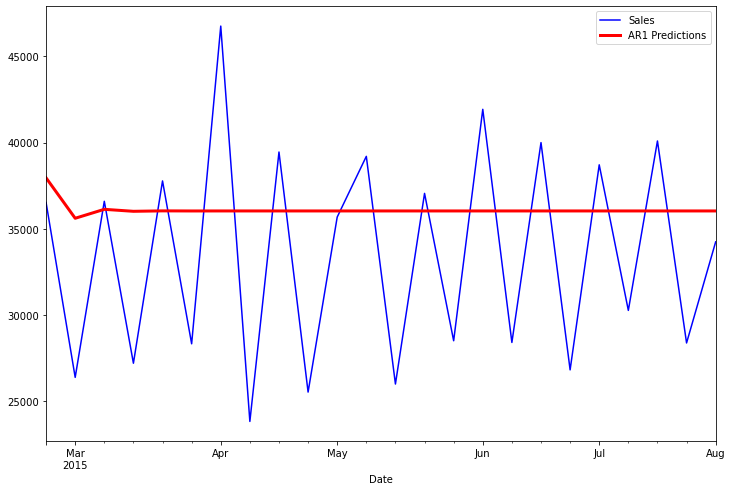

In [50]:

test['Sales'].plot(legend = True, figsize = (12,8), color = 'b');
pred_ar1.plot(color = 'r', linewidth = 3, legend = True)

AR(1) is not helpful here. We can let statsmodel decide what the best value for p.

In [33]:
# let statsmodel fit on different value of P for AR(P)
model = AR(train['Sales'])
AR_fit = model.fit( method = 'mle')
AR_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      S  -                  a                  l
Model:                         AR(12)   Log Likelihood               -1151.558
Method:                           mle   S.D. of innovations           7716.656
Date:                Sun, 10 Jan 2021   AIC                             18.155
Time:                        00:39:42   BIC                             18.496
Sample:                    01-06-2013   HQIC                            18.293
                         - 02-15-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.705e+04   1.03e+04      3.603      0.000    1.69e+04    5.72e+04
L1.Sales      -0.1806      0.094     -1.924      0.054      -0.365       0.003
L2.Sales       0.3916      0.095      4.119      0.000       0.205       0.578
L3.Sales       0.1590      0.102      1.566      0.117      -0.040       0.358
L4.Sales      -0.0363      0.103     -0.353      0.724      -0.237       0.165
L5.Sales      -0.1788      0.101     -1.762      0.078      -0.378       0.020
L6.Sales       0.0445      0.104      0.428      0.669      -0.159       0.248
L7.Sales      -0.0334      0.106     -0.314      0.754      -0.242       0.175
L8.Sales      -0.0975      0.106     -0.920      0.358      -0.305       0.110
L9.Sales       0.0522      0.114      0.459      0.646      -0.171       0.275
L10.Sales      0.0874      0.113      0.770      0.441      -0.135       0.310
L11.Sales     -0.0829      0.106     -0.780      0.436      -0.291       0.125
L12.Sales     -0.1554      0.104     -1.488      0.137      -0.360       0.049
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0847           -0.2951j            1.1241           -0.0423
AR.2             1.0847           +0.2951j            1.1241            0.0423
AR.3             0.8874           -0.7658j            1.1721           -0.1133
AR.4             0.8874           +0.7658j            1.1721            0.1133
AR.5             0.2948           -1.1440j            1.1814           -0.2099
AR.6             0.2948           +1.1440j            1.1814            0.2099
AR.7            -0.4430           -1.0357j            1.1265           -0.3143
AR.8            -0.4430           +1.0357j            1.1265            0.3143
AR.9            -0.9440           -0.8061j            1.2413           -0.3875
AR.10           -0.9440           +0.8061j            1.2413            0.3875
AR.11           -1.1467           -0.2087j            1.1655           -0.4713
AR.12           -1.1467           +0.2087j            1.1655            0.4713
------------------------------------------------------------------------------
"""

In [45]:
# another model with AR(12)
model = AR(train['Sales'])
AR12_fit = model.fit(maxlag = 24, method = 'mle')
AR12_fit.summary()

# get the predictions
start = len(train)
end = len(train)+len(test)-1
pred_ar12 = AR12_fit.predict(start = start, end = end, dynamic= False).rename('AR1 Predictions')


In [46]:
# compare predictions to expected value
for i in range(10):#len(pred_ar1)):
    print('Predicted : {} and Expected = {}'.format( pred_ar12[i], test['Sales'][i]))

Predicted : 38296.708640501645 and Expected = 36523
Predicted : 33341.23096700499 and Expected = 26380
Predicted : 29831.372218990444 and Expected = 36593
Predicted : 34138.81736577399 and Expected = 27200
Predicted : 35416.32347516816 and Expected = 37774
Predicted : 38320.68608259925 and Expected = 28327
Predicted : 38418.02090508513 and Expected = 46755
Predicted : 33879.92206982361 and Expected = 23824
Predicted : 44771.59118941909 and Expected = 39451
Predicted : 36471.287973645696 and Expected = 25526


<AxesSubplot:xlabel='Date'>

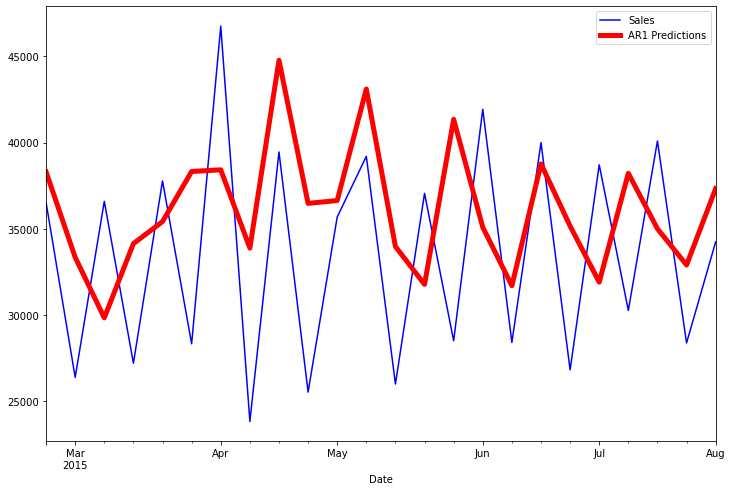

In [47]:

test['Sales'].plot(legend = True, figsize = (12,8), color = 'b');
pred_ar12.plot(color = 'r', linewidth = 5, legend = True)

In [51]:
# Evaluate model
err1 = mean_squared_error(test['Sales'], pred_ar1)
err12 = mean_squared_error(test['Sales'], pred_ar12)

print('AR1 model mean square error is {}'.format(err1))
print('AR19 model mean square error is {}'.format(err12))

AR1 model mean square error is 45605622.072491325
AR19 model mean square error is 47350548.337603904


<AxesSubplot:xlabel='Date'>

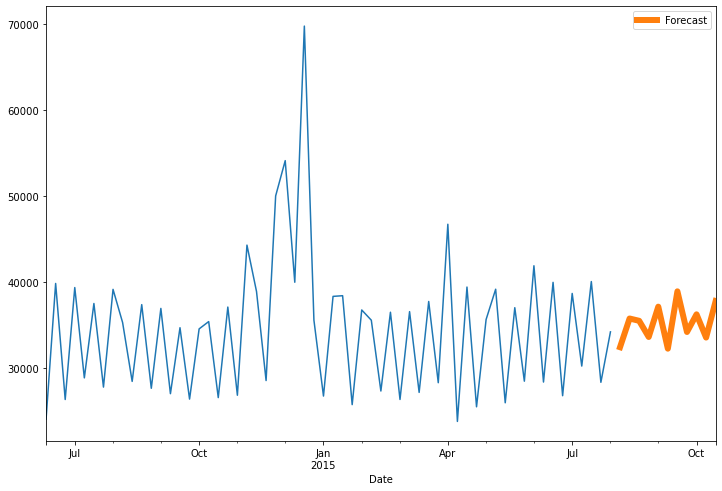

In [53]:
# forecast into future
# using the whole dataset instead of train
model = AR(df['Sales'])
AR_fit = model.fit(maxlag = 24, method = 'mle')

#make prediction for next 10 weeks
forecasted_res = AR_fit.predict(start = (len(df)), end = len(df)+10, dynamic = False).rename('Forecast')

#plot the result
df['Sales'][-60:].plot()
forecasted_res.plot(legend = True, figsize = (12,8), linewidth = 6)

# ARIMA Model

* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.


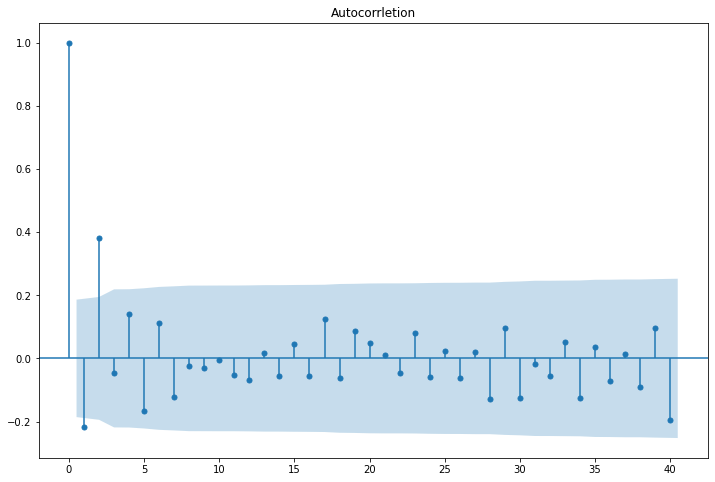

In [54]:
# plotting ACF and PACF
plot_acf(train['Sales'],lags = 40, title = 'Autocorrletion');


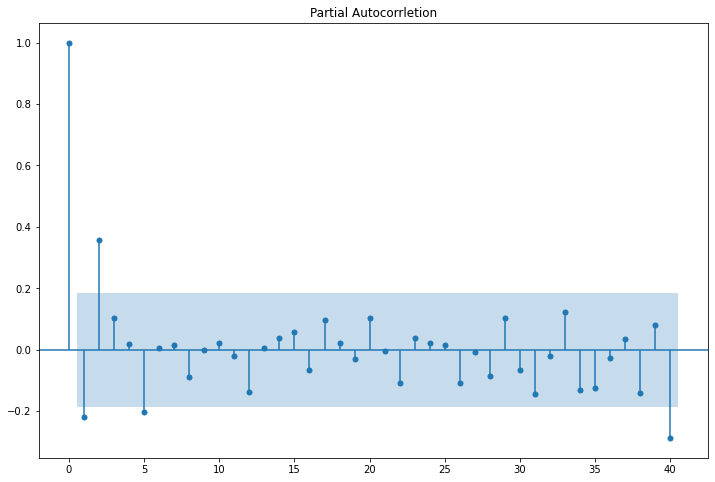

In [55]:
# plotting ACF and PACF
plot_pacf(train['Sales'],lags = 40, title = 'Partial Autocorrletion');



Duke University Statistically Forecasting class:
If the PACF displays a sharp cutoff while the ACF decays more 
slowly (i.e., has significant spikes at higher lags), 
we say that the stationarized series displays an "AR signature,"
meaning that the autocorrelation pattern can be explained more 
easily by adding AR terms than by adding MA terms.


In [69]:
# ARIMA Model
model = ARIMA(train['Sales'], order = (2,0,1))
res_arima = model.fit()
res_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  111
Model:                     ARMA(2, 1)   Log Likelihood               -1155.443
Method:                       css-mle   S.D. of innovations           8013.636
Date:                Sun, 10 Jan 2021   AIC                           2320.887
Time:                        01:14:28   BIC                           2334.434
Sample:                    01-06-2013   HQIC                          2326.383
                         - 02-15-2015                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.593e+04   1058.795     33.933      0.000    3.39e+04     3.8e+04
ar.L1.Sales     0.0360      0.190      0.190      0.849      -0.335       0.407
ar.L2.Sales     0.4001      0.091      4.401      0.000       0.222       0.578
ma.L1.Sales    -0.2079      0.197     -1.053      0.292      -0.595       0.179
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5366           +0.0000j            1.5366            0.0000
AR.2           -1.6266           +0.0000j            1.6266            0.5000
MA.1            4.8098           +0.0000j            4.8098            0.0000
-----------------------------------------------------------------------------
"""

In [70]:
# get the predictions
start = len(train)
end = len(train)+len(test)-1
pred_arima = res_arima.predict(start = start, end = end, dynamic= False).rename('AR1MA Predictions')


<AxesSubplot:xlabel='Date'>

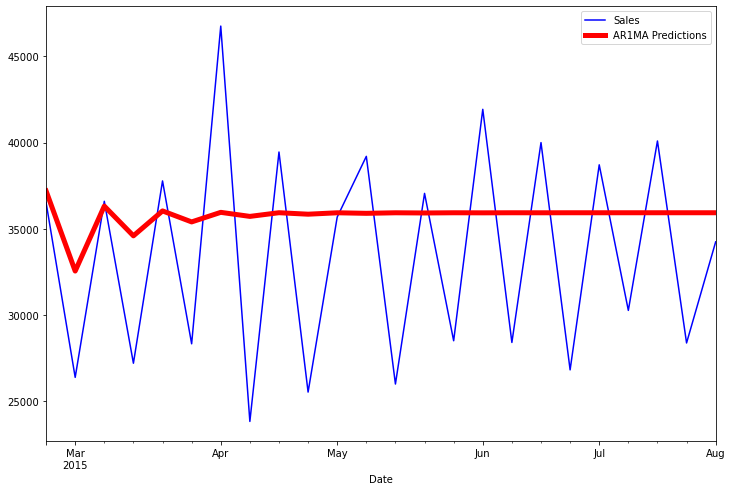

In [71]:

test['Sales'].plot(legend = True, figsize = (12,8), color = 'b');
pred_arima.plot(color = 'r', linewidth = 5, legend = True)

In [72]:
# Evaluate model
err1 = mean_squared_error(test['Sales'], pred_arima)


print('ARIMA model mean square error is {}'.format(err1))


ARIMA model mean square error is 41604750.021722384


<AxesSubplot:xlabel='Date'>

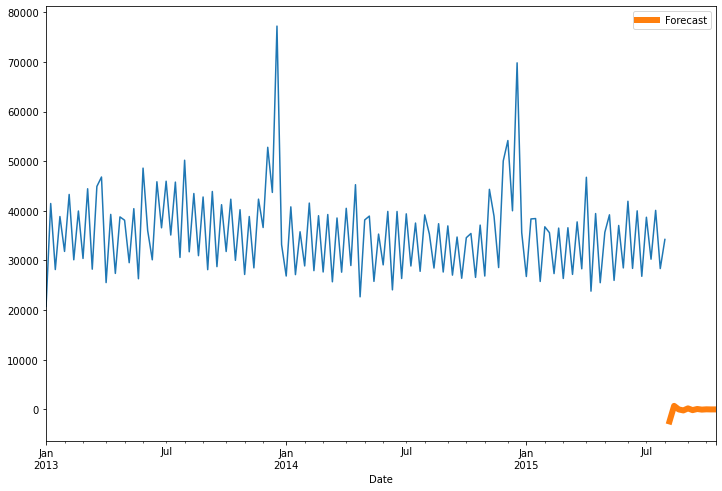

In [73]:
# forecast into future
model = ARIMA(df['Sales'], order = (2,1,0))
AR_fit = model.fit()

#make prediction for next 10 weeks
forecasted_res = AR_fit.predict(start = (len(df)), end = len(df)+10, dynamic = False).rename('Forecast')

#plot the result
df['Sales'][0:].plot()
forecasted_res.plot(legend = True, figsize = (12,8), linewidth = 6)

# SARIMAX(p,d,q) (P,D,Q,m) Model

### Using Auto Arima to find p,d,q

In [74]:
# using Auto ARIMA to check p,d,q
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

res_auto_arima = auto_arima(train['Sales'],
                m=52,
                start_p = 1 , max_p = 6,
                start_q = 1 , max_q = 6, 
                seasonal =True, # diable seasonal component
                d = None, trace=True,
                error_action = 'ignore',  # don't do anything in case of erro
                suppress_warnings = True, # ignore warnings
                stepwise = True
                )
# res_auto_arima.summary()
#Best model:  ARIMA(2,0,0)(0,0,1)[52] intercept

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=2316.945, Time=4.09 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2336.121, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2330.249, Time=1.67 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2323.589, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2652.525, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=2324.959, Time=1.19 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=2315.011, Time=1.79 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=2336.644, Time=0.06 sec
 ARIMA(1,0,1)(2,0,0)[52] intercept   : AIC=2316.996, Time=20.42 sec
 ARIMA(1,0,1)(2,0,1)[52] intercept   : AIC=2318.905, Time=16.98 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=2337.332, Time=1.59 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=2309.788, Time=3.11 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=2321.231, Time=0.08 sec
 ARIMA(2,0,1)(2,0,0)[52] intercept   : AIC=2311.384, Time=22.07 sec
 ARIMA(2,0,1)(1,

In [ ]:
# check auto arima with seasonalities

# auto_arima(train['Sales'], seasonal = True, m=52).summary()
# 

In [76]:
# SARIMA Model
#
model = SARIMAX(train['Sales'],
        order = (2,0,0),
        seasonal_order = (0,0,1,52),
        trend = 'ct'
        )
res_sarima = model.fit()
res_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  111
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 52)   Log Likelihood               -1147.849
Date:                              Sun, 10 Jan 2021   AIC                           2307.698
Time:                                      01:20:14   BIC                           2323.955
Sample:                                  01-06-2013   HQIC                          2314.293
                                       - 02-15-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.934e+04   8480.558      3.460      0.001    1.27e+04     4.6e+04
drift        -16.4802     28.609     -0.576      0.565     -72.553      39.592
ar.L1         -0.1694      0.169     -1.005      0.315      -0.500       0.161
ar.L2          0.3777      0.079      4.806      0.000       0.224       0.532
ma.S.L52       0.4726      0.131      3.597      0.000       0.215       0.730
sigma2      6.387e+07      1.396   4.58e+07      0.000    6.39e+07    6.39e+07
===================================================================================
Ljung-Box (Q):                       26.39   Jarque-Bera (JB):               138.66
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             1.23
Prob(H) (two-sided):                  0.31   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.45e+23. Standard errors may be unstable.
"""

In [77]:
# get the predictions
start = len(train)
end = len(train)+len(test)-1
pred_sarima = res_sarima.predict(start = start, end = end, dynamic= False).rename('AR1MA Predictions')


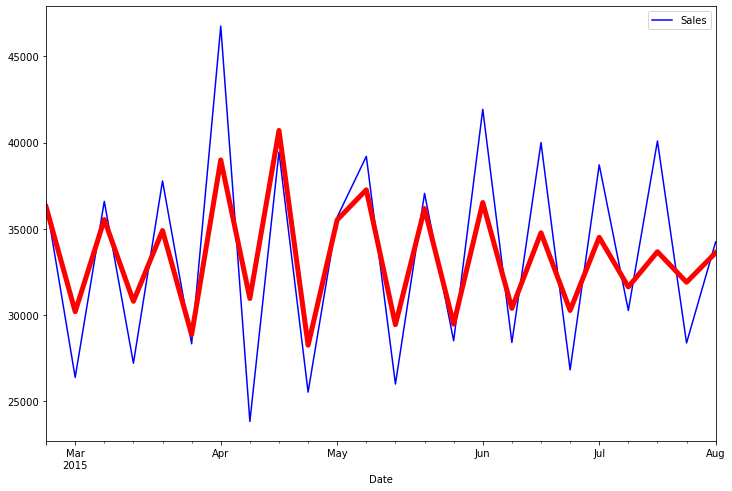

In [78]:

test['Sales'].plot(legend = True, figsize = (12,8), color = 'b');
pred_sarima.plot(color = 'r', linewidth = 5);

In [79]:
# Evaluate model
err1 = mean_squared_error(test['Sales'], pred_sarima)


print('SARIMA model mean square error is {}'.format(err1))


SARIMA model mean square error is 13358752.29643435


<AxesSubplot:xlabel='Date'>

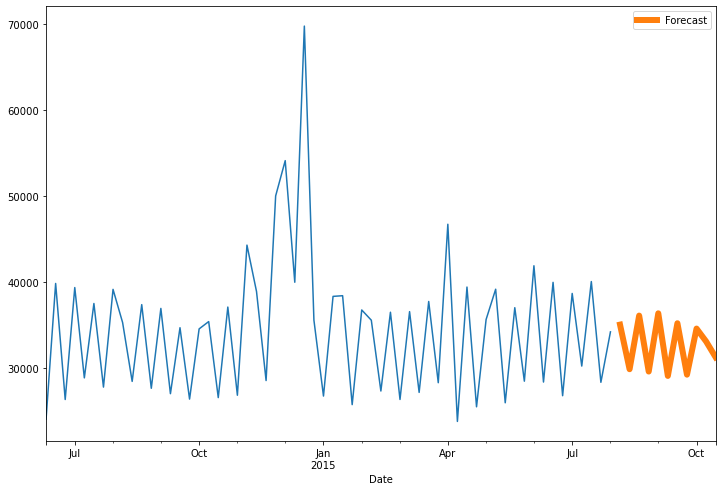

In [80]:
# forecast into future


#make prediction for next 10 weeks
forecasted_res = res_sarima.predict(start = (len(df)), end = len(df)+10, dynamic = False).rename('Forecast')

#plot the result
df['Sales'][-60:].plot()
forecasted_res.plot(legend = True, figsize = (12,8), linewidth = 6)